In [2]:
import lightgbm as lgb
import pandas as pd 
import numpy as np
from category_encoders.cat_boost import CatBoostEncoder
import joblib 
import ast
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import math

In [3]:
s2p = pd.read_pickle('../RawData2/0204_0332_skill2pgm_1차완성_ver0')

In [4]:
s2p['prd_num'] = s2p['판매상품명'].apply(lambda x: len(x))
s2p['상품구분'] = s2p['상품구분'].apply(lambda x: 1 if x=='LIVE' else 0)
s2p = s2p[s2p['상품구분']==1]
s2p['한정표현구분'] = s2p['한정표현구분'].apply(lambda x: sorted(x))
s2p.sort_values(by='방송시작일시',inplace=True)
s2p.reset_index(drop=True,inplace=True)
s2p['쇼호스트명'] = s2p['쇼호스트명'].apply(lambda x: ['없음'] if x is None else x)

In [5]:
s2p['sh_num'].fillna(0,inplace=True)
s2p['sh_grade'].fillna('없음',inplace=True)
s2p['sh_grade_num'].fillna(0,inplace=True)

In [6]:
s2p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14904 entries, 0 to 14903
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   방송편성번호                   14904 non-null  int64         
 1   인입콜                      14904 non-null  int64         
 2   year                     14904 non-null  float64       
 3   month                    14904 non-null  float64       
 4   PGM명                     14904 non-null  object        
 5   상품구분                     14904 non-null  int64         
 6   쇼호스트명                    14904 non-null  object        
 7   날씨                       14904 non-null  object        
 8   기온                       14904 non-null  float16       
 9   강수량                      14904 non-null  float16       
 10  방송시작일시                   14904 non-null  datetime64[ns]
 11  weekday                  14904 non-null  object        
 12  duration                 14904 n

In [7]:
s2p['쇼호스트명'] = s2p['쇼호스트명'].astype(str)
s2p['year'] = s2p['year'].astype(str)
s2p['판매상품명'] = s2p['판매상품명'].astype(str)
s2p['상품대분류명'] = s2p['상품대분류명'].astype(str)
s2p['상품중분류명'] = s2p['상품중분류명'].astype(str)
s2p['상품소분류명'] = s2p['상품소분류명'].astype(str)
s2p['상품세분류명'] = s2p['상품세분류명'].astype(str)
s2p['브랜드명'] = s2p['브랜드명'].astype(str)
s2p['한정표현구분'] = s2p['한정표현구분'].astype(str)

s2p['기온'] = s2p['기온'].astype(float)
s2p['강수량'] = s2p['강수량'].astype(float)

In [8]:
cols_drop = [
  '방송편성번호',
  '인입콜',
  'month',
  'midcat_order_score',
  'midcat_etc_score',
  'midcat_etc_score_mean',
  'midcat_etc_score_max',
  '시차변수',
  'approx_out_show_call'
]

In [9]:
s2p = s2p.drop(cols_drop,axis=1)

In [10]:
from sklearn.model_selection import train_test_split

X = s2p.drop('approx_in_show_call',axis=1)
y= s2p.approx_in_show_call

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
shuffle=False,
random_state=42)

In [11]:
target_trans = lambda call_: np.log1p(call_) **1.6
target_inv_trans = lambda call_: np.expm1(call_ ** (10/16))

In [12]:
y_train = target_trans(y_train)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scs
def show_hist(values):
    plt.figure(1, figsize=(10, 6))
    sns.distplot(values)
    plt.show()
    
    print('skew:', scs.skew(values))
    print('kurtosis:', scs.kurtosis(values))

/Users/beomso0/miniforge3/envs/pr_tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


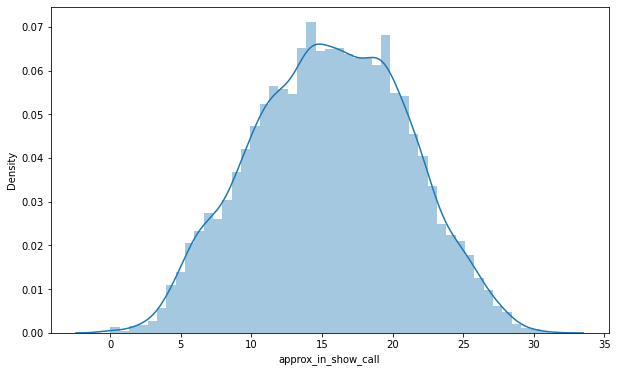

skew: -0.047162638369427974
kurtosis: -0.5358598369466394


In [14]:
show_hist(y_train)

In [15]:
cat_features = ['year','PGM명','쇼호스트명','날씨','weekday','판매상품명','상품대분류명','상품중분류명','상품소분류명','상품세분류명','브랜드명','한정표현구분','sh_grade']
drop_cols = ['상품구분','방송시작일시','상품판매가']

In [16]:
X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

X_train.drop(drop_cols,axis=1,inplace=True)
X_test.drop(drop_cols,axis=1,inplace=True)

In [17]:
pd.set_option('display.max_columns',None)

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
%%time
ce = CatBoostEncoder()
ce.fit(X_train[cat_features], y_train)

CPU times: user 234 ms, sys: 9.84 ms, total: 244 ms
Wall time: 261 ms


CatBoostEncoder(cols=['year', 'PGM명', '쇼호스트명', '날씨', 'weekday', '판매상품명',
                      '상품대분류명', '상품중분류명', '상품소분류명', '상품세분류명', '브랜드명', '한정표현구분',
                      'sh_grade'])

In [20]:
scale_features = ['기온','강수량','duration','판매가평균','midcat_order_score_mean','midcat_order_score_max','한정표현_num','sh_num','sh_grade_num','소비지수','prd_num','day_sin',	'day_cos',	'hour_sin',	'hour_cos',	'month_sin',	'month_cos']

In [21]:
X_train[cat_features] = ce.transform(X_train[cat_features])
ms = MinMaxScaler()
scaled_df = ms.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns, index=list(X_train.index.values))
X_train.head()

,year,PGM명,쇼호스트명,날씨,기온,강수량,weekday,duration,판매상품명,상품대분류명,상품중분류명,상품소분류명,상품세분류명,브랜드명,판매가평균,midcat_order_score_mean,midcat_order_score_max,한정표현구분,한정표현_num,주말/공휴일,sh_num,sh_grade,sh_grade_num,소비지수,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,prd_num
0,1.0,0.463637,0.497076,0.208679,0.259259,0.0,0.285757,0.266667,0.591971,0.641422,0.612231,0.615084,0.732943,0.532020,0.000905,0.25,0.25,0.628231,0.25,0.0,0.4,0.550804,0.4,0.851351,0.786001,0.910151,0.629410,0.017037,0.75,0.933013,0.015385
1,1.0,0.486212,0.472703,0.208679,0.259259,0.0,0.097541,0.200000,0.591971,0.552725,0.567943,0.614615,0.518437,0.488133,0.006694,0.25,0.25,0.268533,0.25,0.0,0.2,0.363131,0.2,0.851351,1.000000,0.473324,0.853553,0.146447,0.75,0.933013,0.000000
2,1.0,0.877380,0.933114,0.014861,0.333333,0.0,0.097541,0.511111,0.591971,1.000000,0.840818,1.000000,0.524427,0.490350,0.002786,0.40,0.50,0.628231,0.25,1.0,0.2,1.000000,1.0,0.851351,0.600779,0.989739,0.853553,0.146447,0.75,0.933013,0.061538
3,1.0,0.563059,0.625419,0.014861,0.333333,0.0,0.167390,0.266667,0.591971,0.578459,0.580194,0.652212,0.584735,0.601607,0.000921,0.00,0.00,0.094701,0.00,0.0,0.4,0.667007,0.6,0.851351,0.697431,0.959375,0.750000,0.066987,0.75,0.933013,0.000000
4,1.0,0.441691,0.563225,0.014861,0.370370,0.0,0.097541,0.200000,0.591971,0.388347,0.372666,0.360754,0.524427,0.520149,0.044065,0.00,0.00,0.268533,0.25,1.0,0.4,0.550804,0.4,0.851351,0.600779,0.989739,0.629410,0.017037,0.75,0.933013,0.107692


In [22]:
X_test[cat_features] = ce.transform(X_test[cat_features])
scaled_test_df = ms.fit_transform(X_test)
X_test = pd.DataFrame(scaled_test_df, columns=X_test.columns, index=list(X_test.index.values))
X_test.head()

,year,PGM명,쇼호스트명,날씨,기온,강수량,weekday,duration,판매상품명,상품대분류명,상품중분류명,상품소분류명,상품세분류명,브랜드명,판매가평균,midcat_order_score_mean,midcat_order_score_max,한정표현구분,한정표현_num,주말/공휴일,sh_num,sh_grade,sh_grade_num,소비지수,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,prd_num
13413,0.0,0.688422,0.733104,0.764057,0.916667,0.0,0.097541,0.235294,0.581228,0.504192,0.564802,0.576357,0.696048,0.547248,0.000845,0.50,0.50,0.192016,0.333333,0.0,0.666667,0.550804,0.4,0.783784,0.137138,0.844083,0.629410,0.017037,0.0,0.0,0.069767
13414,0.0,0.775712,0.843352,0.764057,0.916667,0.0,0.066006,0.235294,0.327534,0.145727,0.172614,0.182672,0.212778,0.242419,0.000845,0.50,0.50,0.000000,0.000000,0.0,0.666667,0.667007,0.6,0.783784,0.075133,0.763876,0.146447,0.146447,0.0,0.0,0.000000
13415,0.0,0.479154,0.599460,0.764057,0.916667,0.0,0.066006,0.235294,0.581228,0.501939,0.513731,0.498678,0.965095,0.547248,0.001258,0.50,0.50,0.589341,0.333333,0.0,0.666667,0.667007,0.6,0.783784,0.075133,0.763876,0.146447,0.146447,0.0,0.0,0.023256
13416,0.0,0.479154,0.255355,0.764057,0.833333,0.0,0.097541,0.588235,0.581228,0.525605,0.472731,0.475102,0.569872,0.502563,0.044386,0.00,0.00,0.192016,0.333333,0.0,0.333333,0.000000,0.0,0.783784,0.137138,0.844083,0.250000,0.066987,0.0,0.0,0.116279
13417,0.0,0.427789,0.626176,0.764057,0.833333,0.0,0.097541,0.235294,0.581228,0.447108,0.438609,0.494537,0.584759,0.578062,0.003610,0.25,0.25,0.192016,0.333333,0.0,0.666667,0.880887,0.8,0.783784,0.137138,0.844083,0.066987,0.250000,0.0,0.0,0.046512


In [ ]:
# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
lgb_reg = lgb.LGBMRegressor(n_estimators=3000, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
lgb_reg.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)])

/Users/beomso0/miniforge3/envs/pr_tensorflow/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's rmse: 4.99591	training's l2: 24.9591	valid_1's rmse: 650.686	valid_1's l2: 423392
[2]	training's rmse: 4.61419	training's l2: 21.2907	valid_1's rmse: 650.42	valid_1's l2: 423046
[3]	training's rmse: 4.27558	training's l2: 18.2806	valid_1's rmse: 650.207	valid_1's l2: 422769
[4]	training's rmse: 3.97715	training's l2: 15.8177	valid_1's rmse: 649.993	valid_1's l2: 422491
[5]	training's rmse: 3.71535	training's l2: 13.8038	valid_1's rmse: 649.806	valid_1's l2: 422248
[6]	training's rmse: 3.4844	training's l2: 12.1411	valid_1's rmse: 649.653	valid_1's l2: 422050
[7]	training's rmse: 3.28269	training's l2: 10.7761	valid_1's rmse: 649.509	valid_1's l2: 421863
[8]	training's rmse: 3.10809	training's l2: 9.66025	valid_1's rmse: 649.387	valid_1's l2: 421703
[9]	training's rmse: 2.95256	training's l2: 8.71762	valid_1's rmse: 649.263	valid_1's l2: 421543
[10]	training's rmse: 2.81977	training's l2: 7.95113	valid_1's rmse: 649.134	valid_1's l2: 421375
[11]	training's rmse: 2.70181	t

LGBMRegressor(n_estimators=3000, random_state=156)

In [ ]:
pred = pd.Series(target_inv_trans(lgb_reg.predict(X_test)))

In [ ]:
mae = mean_absolute_error(y_test,pred)
mape = mean_absolute_percentage_error(y_test,pred)
rmse = math.sqrt(mean_squared_error(y_test,pred))

print(
    f'MAE: {mae}',
    f'MAPE: {mape}',
    f'RMSE: {rmse}',
)

MAE: 180.4721013862536 MAPE: 412570887416740.8 RMSE: 308.6347539985523


In [ ]:
from sklearn.model_selection import GridSearchCV

tunned_lgb = lgb.LGBMRegressor()

params = {'max_depth':[5,7,9,11,13,15,17], 'min_child_weight':[5,7,9,11,13], 'colsample_bytree':[0.5, 0.75],'n_estimators':[2000,3000],'learning_rate':[0.1,0.01]}

gridcv = GridSearchCV(tunned_lgb, param_grid=params, cv=3, verbose=0, n_jobs=-1)
gridcv.fit(X_train, y_train, early_stopping_rounds=70, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, target_trans(y_test))])

In [ ]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.75, 'max_depth': 11, 'min_child_weight': 5, 'n_estimators': 2000}


In [ ]:
params = {
  'colsample_bytree': 0.75, 
  'max_depth': 11, 
  'min_child_weight': 5, 
  'n_estimators': 2000
}

In [ ]:
final_lgb = lgb.LGBMRegressor(
  colsample_bytree= 0.75, 
  max_depth=11, 
  min_child_weight=5, 
  n_estimators=2000
)

final_lgb.fit(X_train, y_train, early_stopping_rounds=1000,
            eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, target_trans(y_test))])

[1]	training's rmse: 5.01513	training's l2: 25.1516	valid_1's rmse: 5.46704	valid_1's l2: 29.8885
[2]	training's rmse: 4.62947	training's l2: 21.432	valid_1's rmse: 5.06081	valid_1's l2: 25.6118
[3]	training's rmse: 4.28805	training's l2: 18.3874	valid_1's rmse: 4.71298	valid_1's l2: 22.2122
[4]	training's rmse: 3.98762	training's l2: 15.9011	valid_1's rmse: 4.41784	valid_1's l2: 19.5173
[5]	training's rmse: 3.72996	training's l2: 13.9126	valid_1's rmse: 4.20483	valid_1's l2: 17.6806
[6]	training's rmse: 3.4986	training's l2: 12.2402	valid_1's rmse: 3.97863	valid_1's l2: 15.8295
[7]	training's rmse: 3.30245	training's l2: 10.9062	valid_1's rmse: 3.78654	valid_1's l2: 14.3379
[8]	training's rmse: 3.13093	training's l2: 9.80271	valid_1's rmse: 3.61839	valid_1's l2: 13.0928
[9]	training's rmse: 2.99081	training's l2: 8.94497	valid_1's rmse: 3.51371	valid_1's l2: 12.3462
[10]	training's rmse: 2.85333	training's l2: 8.14149	valid_1's rmse: 3.38656	valid_1's l2: 11.4688
[11]	training's rmse:

LGBMRegressor(colsample_bytree=0.75, max_depth=11, min_child_weight=5,
              n_estimators=2000)

In [ ]:
mae = mean_absolute_error(y_test,target_inv_trans(final_lgb.predict(X_test)))
mape = mean_absolute_percentage_error(y_test,target_inv_trans(final_lgb.predict(X_test)))
rmse = math.sqrt(mean_squared_error(y_test,target_inv_trans(final_lgb.predict(X_test))))

print(
    f'MAE: {mae}',
    f'MAPE: {mape}',
    f'RMSE: {rmse}',
)

MAE: 151.9073062387149 MAPE: 365487746373653.9 RMSE: 272.5684168049894


In [ ]:
import joblib 
joblib.dump(final_lgb,'test_lgb.pkl')

['test_lgb.pkl']

In [ ]:
loaded_model = joblib.load('test_lgb.pkl')

In [ ]:
mae = mean_absolute_error(y_test,target_inv_trans(loaded_model.predict(X_test)))
mae

151.9073062387149